In [17]:
!pip install -q scikit-bio
!pip install -q matplotlib
!pip install -q scikit-learn
!pip install -q cvxopt
!pip install -q tensorflow

# **CUSUM - Deep SVDD + ilr transform**

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
from sklearn.base import BaseEstimator, OutlierMixin
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.model_selection import train_test_split
from cvxopt import matrix, solvers
from scipy.stats import norm

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
# FUNCTIONS

class DeepSVDD(BaseEstimator, OutlierMixin):
    # Trước khi tìm cách tối ưu
    # latent_dim = 4, epochs = 200, lr = 1e-4
    # subgroup_size = 3
    def __init__(self, latent_dim=8, epochs=600, lr=1e-4, display='on'):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.lr = lr
        self.C = None
        self.kernel = None
        self.degree = None
        self.gamma = None
        self.coef0 = None
        self.n_jobs = None
        self.display = display
        self.X = None
        self.y = None
        self.weight = None
        self.exist_label = True
        self.label_type = None
        self.support_vectors = None
        self.support_vector_indices = None
        self.n_support_vectors = None
        self.n_iterations = None
        self.object_value = None
        self.alpha = None
        self._tolerance = 1e-6
        self.support_vector_alpha = None
        self.n_support_vectors_ratio = None
        self.radius = None
        self.center = None
        self.offset = None
        self.distance = None
        self.accuracy = None
        self.predicted_y = None
        self.running_time = None
        self.boundary_indices = None
        self.classes_ = None
        self.nu = 0.1
        self.R = tf.Variable(0.1, dtype=tf.float32, trainable=True)


    @property
    def n_samples(self):
        return self.X.shape[0]
    @property
    def n_features(self):
        return self.X.shape[1]
    @property
    def n_positive_samples(self):
        return np.sum(self.y == 1)
    @property
    def n_negative_samples(self):
        return np.sum(self.y == -1)


    def fit(self, X, y=None, weight=None):

        start_time = time.time()
        # parameter preprocessing
        self.X, self.y, self.y_type, self.exist_y = self._check_X_y(X, y)

        n_samples, n_features = self.X.shape
        X_tensor = tf.convert_to_tensor(self.X, dtype=tf.float32)
        self.encoder = tf.keras.Sequential([
        layers.Input(shape=(n_features,)),
        #layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        #layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dense(self.latent_dim, activation=None)   # latent output φ(x)
    ])

        optimizer = optimizers.Adam(learning_rate=self.lr)
        # Initialize hypersphere center (mean of initial embeddings)
        Z_init = self.encoder(X_tensor, training=False)
        self.center = tf.reduce_mean(Z_init, axis=0).numpy()

        self.loss_history = []
        # Train encoder to minimize distance to center
        for epoch in range(self.epochs):
            with tf.GradientTape() as tape:
                Z = self.encoder(X_tensor, training=True)
                #dist = tf.reduce_sum(tf.square(Z - self.center), axis=1)
                #loss = tf.reduce_mean(dist)
                dist = tf.reduce_sum(tf.square(Z - self.center), axis=1)
                term1 = tf.square(self.R)

                # hinge loss
                term2 = (1 / self.nu) * tf.reduce_mean(tf.nn.relu(dist - tf.square(self.R)))

                loss = term1 + term2
                # L2 regularization
                for w in self.encoder.trainable_weights:
                    loss += 1e-4 * tf.nn.l2_loss(w)

            grads = tape.gradient(loss, self.encoder.trainable_weights)
            optimizer.apply_gradients(zip(grads, self.encoder.trainable_weights))

            # 14/11 - bổ sung hiển thị biểu đồ loss 
            loss_value = loss.numpy()
            self.loss_history.append(loss_value)

            if (epoch + 1) % 10 == 0 and self.display == 'on':
                print(f"Epoch {epoch+1:03d}/{self.epochs} - Loss: {loss.numpy():.6f}")

        # Compute final embeddings & update center, radius
        Z_final = self.encoder(X_tensor, training=False).numpy()
        #self.center = np.mean(Z_final, axis=0)
        #distances = np.linalg.norm(Z_final - self.center, axis=1)
        distances = np.sum((Z_final - self.center)**2, axis=1) 
        #self.radius = np.percentile(distances, 99)   # 95% CL, same as SVDD upper limit
        #self.radius = np.sqrt(np.percentile(distances, 100*(1-self.nu)))
        #self.radius = np.percentile(distances, 100 * (1 - self.nu))
        self.radius = self.R.numpy()
        display_ = self.display
        self.display = 'off'
        self.predicted_y_ = self.predict(self.X, self.y)
        #self.accuracy = accuracy_score(self.y, self.predicted_y_)
        self.display = display_
        end_time = time.time()
        self.running_time = end_time - start_time

        # display
        if self.display == 'on':
           self.display_fit()
        return self

    def predict(self, X, y=None):

        start_time = time.time()
        results = {}
        results['X'], results['y'], results['y_type'], results['exist_y'] = self._check_X_y(X, y)
        results['n_samples'] = results['X'].shape[0]
        #
        results['distance'] = self.get_distance(X)
        results['predicted_y'] = np.asmatrix(np.ones(results['n_samples'])).T
        index_ = results['distance'] > self.radius
        results['predicted_y'][index_] = -1
        results['predicted_y'] = np.asarray(results['predicted_y'])
        results['n_alarm'] = np.sum(index_==True)
        #
        if results['exist_y'] == True:
            results['accuracy'] = accuracy_score(results['y'], results['predicted_y'])

        end_time = time.time()
        results['running_time'] = end_time - start_time
        # display
        if self.display == 'on':
            self.display_predict(results)
        return results['predicted_y']
    
    def get_distance(self, X):

        # Convert input to tensor and encode to latent space
        X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
        Z = self.encoder(X_tensor)   # latent representation φ(x)
        Z_np = Z.numpy()

        # Compute distance to center (Euclidean norm)
        #distances = np.linalg.norm(Z_np - self.center, axis=1)
        distances = np.sum((Z_np - self.center)**2, axis=1)
        # Reshape to column vector for compatibility
        return distances

    def get_params(self, deep=True):

        out = dict()
        for key in self._get_param_names():
            value = getattr(self, key)
            if deep and hasattr(value, "get_params"):
                deep_items = value.get_params().items()
                out.update((key + "__" + k, val) for k, val in deep_items)
            out[key] = value
        return out

    def _check_X_y(self, X, y):

        # check for labels
        if y is None:
            y = np.ones((X.shape[0], 1))
            exist_y = False
        else:
            exist_y = True

        # check for object type (numpy.ndarray)
        if type(X) is not np.ndarray or type(y) is not np.ndarray:
            raise SyntaxError("The type of X and y must be 'numpy.ndarray'.\n")

        # check for data dimensionality
        if len(X.shape) != 2 or len(y.shape) != 2:
            raise SyntaxError("The X and y must be 2D.\n")

        # check for data length
        if X.shape[0] != y.shape[0]:
            raise SyntaxError("The length of X and y must the same.\n")

        # check for label values
        tmp_ = np.unique(y)
        if np.all(tmp_ == np.array([1])) or np.all(tmp_ == np.array([-1])):
            y_type = 'single'

        elif np.all(tmp_ == np.array([1, -1])) or np.all(tmp_ == np.array([-1, 1])):
            y_type = 'hybrid'

        else:
            errorText = "SVDD is only supported for one-class or binary classification. "\
                        "The label must be 1 for positive samples or -1 for negative samples.\n"
            raise SyntaxError(errorText)

        self.classes_ = np.unique(y)

        return X, y, y_type, exist_y

    def display_fit(self):
        # display the fitting results
        print('\n')
        print('*** Fitting of the SVDD model is completed. ***\n')
        print('running time         = %.4f seconds'   % self.running_time)

        print('number of samples    = %d'             % self.n_samples)
        print('number of features   = %d'             % self.n_features)
        #print('latent dim           = %d'             % self.latent_dim)
        #print('Radius               = %.4f'           % self.radius)
        #print(f'Latent dim          = {self.latent_dim}')
        #print(f'Radius (95%)        = {self.radius:.4f}')
        print('accuracy             = %.4f %%'        % (100*self.accuracy))
        print('\n')

    def display_predict(self, results):
        # display test results
        print('\n')
        print('*** Prediction of the provided data is completed. ***\n')
        print('running time         = %.4f seconds'   % results['running_time'])
        print('number of samples    = %d'             % results['n_samples'])
        print('number of alarm      = %d'             % results['n_alarm'])
        if results['exist_y'] == True:
            print('accuracy             = %.4f %%'        % (100*results['accuracy']))
        print('\n')
    # 14/11 - bổ sung hàm plot loss
    def plot_loss(self):
        if not hasattr(self, "loss_history"):
            print("No loss history. Train the model first.")
            return

        plt.figure(figsize=(8, 5))
        plt.plot(self.loss_history, linewidth=2)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss Curve (DeepSVDD)")
        plt.grid(True)
        plt.show()

    def plot_distance(self, radius, distance):


        n = distance.shape[0]
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(1, 1, 1)
        radius = np.ones((n, 1))*radius

        ax.plot(radius,
                color='r',
                linestyle='-',
                marker='None',
                linewidth=3,
                markeredgecolor='k',
                markerfacecolor='w',
                markersize=6)

        ax.plot(distance,
                color='k',
                linestyle=':',
                marker='o',
                linewidth=1,
                markeredgecolor='k',
                markerfacecolor='C4',
                markersize=6)

        ax.set_xlabel('Samples')
        ax.set_ylabel('Distance')

        ax.legend(["Control Limit", "Distance"],
                  ncol=1, loc=0,
                  edgecolor='black',
                  markerscale=1, fancybox=True)
        ax.yaxis.grid()
        plt.show()

    def plot_distanceV(self, radius, distance):
        n = distance.shape[0]
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(1, 1, 1)
        radius = np.ones((n, 1))*radius

        ax.plot(radius,
                color='r',
                linestyle='-',
                marker='None',
                linewidth=3,
                markeredgecolor='k',
                markerfacecolor='w',
                markersize=6)

        ax.plot(distance,
            color='k',
            linestyle=':',
            marker='o',
            linewidth=1,
            markeredgecolor='k',
            markerfacecolor='C4',
            markersize=6)

        ax.set_xlabel('Samples')
        ax.set_ylabel('Distance')

        # Add sample labels
        sample_labels = [str(i+1) for i in range(n)]  # Sample numbers from 1 to n
        ax.set_xticks(np.arange(n))
        ax.set_xticklabels(sample_labels)

        ax.legend(["Control Limit", "Distance"],
                  ncol=1, loc=0,
                  edgecolor='black',
                  markerscale=1, fancybox=True)
        ax.yaxis.grid()
        plt.show()


def D_density(A, alpha):
    N = np.zeros(A.shape[0]).reshape(A.shape[0], 1)
    for i in range(A.shape[0]):
        N[i] = Dir.pdf(A[i], alpha)  # Convert to Dir-density
    return N


#**CUSUM-Deep SVDD control chart using ilr transformation**

In [19]:
#  Functions
def ilr_manual(X):
    """
    ILR transform for 3-part compositional data
    X: (n, 3), rows sum to 1
    """
    x1, x2, x3 = X[:, 0], X[:, 1], X[:, 2]

    z1 = np.sqrt(2/3) * np.log(np.sqrt(x1 * x2)/x3)
    z2 = np.sqrt(1/2) * np.log(x1 / x2)

    return np.column_stack((z1, z2))
def Subgroup(X, m):
    Xbar = np.zeros((1, X.shape[1]))
    for i in range(int(X.shape[0] / m)):
        xbar = np.mean(X[m * i:m * (i + 1)], axis=0)
        Xbar = np.concatenate((Xbar, xbar.reshape(1, -1)))
    return Xbar[1:int(X.shape[0] / m + 1)]
'''
def control_limit(svdd, M, beta, error):
    # X = data, Beta = 1/ARL0 - ARL0 = 100
    #svdd = DeepSVDD(latent_dim=latent_dim, lr=lr, epochs=epochs, display='off')
    #svdd.fit(X)
    h = []
    for j in range(M):
        X1 = np.array(random.choices(svdd.X, k=svdd.X.shape[0]))
        distance = svdd.get_distance(X1)
        h_j = np.percentile(distance.tolist(), 100 * (1 - beta))
        h.append(h_j)
    h_cl = np.percentile(h, 100 * (1 - error))
    return h_cl
'''
'''
def ARL0_markov_chain2(K, h, mu0=0, sigma0=1, m=200, side='two'):
    w = (2 * h) / (2 * m - 1)
    Q = np.zeros((m, m))

    states = np.array([w/2 + i*w for i in range(m)])

    for i in range(m):
        current_val = states[i]

        for j in range(m):

            z_low  = (states[j] - w/2) - current_val + K
            z_high = (states[j] + w/2) - current_val + K

            if j == 0:

                prob = norm.cdf(z_high)
            else:
                prob = norm.cdf(z_high) - norm.cdf(z_low)

            Q[i, j] = prob

    try:
        I = np.eye(m)
        N = np.linalg.inv(I - Q)


        ones = np.ones((m, 1))

        ARL_vector = np.matmul(N, ones)

        arl_onesided = ARL_vector[0, 0]

        if side == 'two':

            return arl_onesided / 2
        else:
            return arl_onesided

    except np.linalg.LinAlgError:
        print("Lỗi: Không thể nghịch đảo ma trận. Hãy thử thay đổi kích thước m.")
        return 0.0
'''
'''
def ARL0_MC(svdd, alpha0, m, h, k, mu0, sigma0, M=100, max_len=5000):
    RL = []

    for j in range(M):
        C_pos = 0.0
        C_neg = 0.0

        for t in range(1000):

            # IC data
            X_new = Dir.rvs(alpha0, size=m)
            X_new_ilr = ilr_manual(X_new)
            
            Xbar = X_new_ilr.mean(axis=0).reshape(1, -1)

            dist = svdd.get_distance(Xbar)[0]
            z = (dist - mu0) / sigma0

            C_pos = max(0, C_pos + z - k)
            C_neg = max(0, C_neg - z - k)

            if C_pos > h or C_neg > h:
                RL.append(t + 1)
                break
        else:
            RL.append(1000)

    return np.mean(RL)
'''
'''
def control_limit_markov(K, mu0, sigma0, ARL0_target=100, h_low=0.1, h_high=50, tol=1e-3, M=100):

    while abs(h_high - h_low) > tol:
        h_mid = (h_low + h_high) / 2
        #arl = ARL0_markov_chain(K, h_mid, mu0, sigma0, M)
        #print(arl)
        #arl = ARL0_markov_chain_exact(K, h_mid, mu0, sigma0, p=800)
        #arl = ARL0_markov_chain_corrected(K, h_mid, mu0, sigma0, side='two')
        arl0 = ARL0_MC(svdd, alpha0, m, h_mid, k, mu0, sigma0, M=300)

        print(f"h={h_mid:.3f}, ARL0={arl0:.2f}")
        if arl > ARL0_target:
            h_high = h_mid
        else:
            h_low = h_mid
    return (h_low + h_high) / 2
'''
def find_h_MC(svdd, alpha0, m, M, k, mu0, sigma0,
              ARL0_target=370, h_low=0.1, h_high=50,
              tol=0.05):
    h_mid = 0.5 * (h_low + h_high)
    arl0 = simulate_RL_IC(svdd, m, M, alpha0, k, h_mid, mu0, sigma0)
    i = 1
    #while abs(h_high - h_low) > tol :
    while abs(arl0 - ARL0_target) > tol :
        h_mid = 0.5 * (h_low + h_high)
        #arl0 = ARL0_MC(svdd, alpha0, m, h_mid, k, mu0, sigma0, M=300)
        i = i+1
        arl0 = simulate_RL_IC(svdd, m, M, alpha0, k, h_mid, mu0, sigma0)
        #print(f"h={h_mid:.3f}, ARL0={arl0:.4f}")

        if arl0 > ARL0_target:
            h_high = h_mid
        else:
            h_low = h_mid
    print("Số vòng lặp", i)
    return 0.5 * (h_low + h_high)

def Characters_RL_CUSUM(svdd, M, m, h, alpha1, k, mu0, sigma0, max_len=1000):
    RL = []

    for j in range(M):
        C_pos = 0.0
        C_neg = 0.0

        for t in range(max_len):

            # 1. Generate new subgroup (OOC)
            X_new = Dir.rvs(alpha1, size=m)
            X_new_ilr = ilr_manual(X_new)
            #X_new_ilr = ilr(X_new, validate=False)
            #Xbar = X_new_ilr.mean(axis=0).reshape(1, -1)
            Xbar = Subgroup(X_new_ilr, m)
            
            # 2. Deep SVDD distance
            dist = svdd.get_distance(Xbar)[0]

            # 3. Standardize using Phase I statistics
            z = (dist - mu0) / sigma0

            # 4. Standard CUSUM
            C_pos = max(0, C_pos + z - k)
            C_neg = max(0, C_neg - z - k)
            #C_pos = max(0, C_pos + (dist-mu0-k*sigma0))
            #C_neg = max(0, C_neg + (dist-mu0+k*sigma0))
            if C_pos > h or C_neg > h:
                RL.append(t + 1)
                break
        else:
            RL.append(max_len)
    print(RL)
    return {
        "ARL1": np.mean(RL),
        "SDRL": np.std(RL),
        "MRL": np.median(RL)
    }

def simulate_RL_IC(svdd, m, M, alpha, k, h, mu, sigma):
    RL = []
    for i in range(M):
        C_pos = 0
        C_neg = 0

        for j in range(1000):
            X_new = Dir.rvs(alpha, size=m)
            X_new_ilr = ilr_manual(X_new)
            #X_new_ilr = ilr(X_new, validate=False)
            #Xbar = X_new_ilr.mean(axis=0).reshape(1, -1)
            Xbar = Subgroup(X_new_ilr, m)
            # 2. Deep SVDD distance
            distance = svdd.get_distance(Xbar)
            #print(distance)
            dist = distance[0]

            # 3. Standardize using Phase I statistics
            z = (dist - mu) / sigma

            # 4. Standard CUSUM
            C_pos = max(0, C_pos + z - k)
            #C_pos = max(0, C_pos + (dist-mu-k*sigma))
            #C_neg = max(0, C_neg + (dist-mu+k*sigma))
            C_neg = max(0, C_neg - z - k)

            if C_pos > h or C_neg > h:
                RL.append(j + 1)
                break
        else:
            RL.append(1000)
    #print(RL)
    
    return round(np.mean(RL),4)


def generate_ooc_distances(
    alpha1,
    svdd,
    n=2000,
    m=5,
):
    """
    Sinh OOC distances Y_t từ Dirichlet(alpha1)
    Trả về vector distances
    """

    # 1. Sinh n mẫu OOC
    X_ooc = Dir.rvs(alpha1, size=n)
    X_ooc = X_ooc / X_ooc.sum(axis=1, keepdims=True)

    # 2. ILR transform
    X_ilr = ilr_manual(X_ooc)   # shape (n, d-1)

    # 3. Chia subgroup
    n_groups = n // m
    X_ilr = X_ilr[:n_groups * m]
    X_groups = X_ilr.reshape(n_groups, m, -1)

    # 4. Tính distance cho từng subgroup
    Y = []

    for g in range(n_groups):
        Z = X_groups[g]                 # (m, latent_dim)
        Z_embed = svdd.encoder(Z)       # latent
        dist = svdd.distance(Z_embed)   # hoặc svdd(Z)
        Y.append(np.mean(dist))         # subgroup statistic

    return np.array(Y)



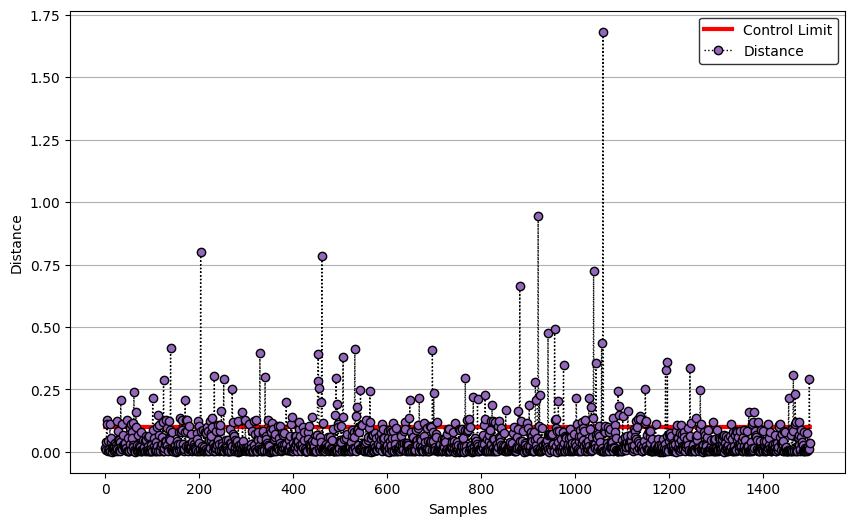

Center = [-0.15640037  0.25667202 -0.05498112  0.12690611 -0.0345076   0.01937586
 -0.13072003 -0.12599957]
Radius = 0.1
Max distance = 1.6812677
Mean distance (mu): 0.04825534
Std distance (sigma): 0.08495684
k_CUSUM [0.007009734865278006, 0.01036981213837862, 0.027641117572784424, 0.06953851133584976]
Processing dataset C_0.07009734865278006:
Số vòng lặp 190
h* = 10.625840736163756
[31, 216, 183, 125, 113, 138, 45, 78, 248, 180, 151, 29, 182, 57, 78, 138, 244, 69, 93, 47, 228, 61, 108, 145, 34, 70, 92, 105, 135, 85, 87, 74, 104, 171, 104, 89, 49, 69, 106, 143, 102, 106, 122, 89, 80, 115, 112, 118, 95, 109, 16, 103, 161, 138, 37, 47, 133, 56, 42, 186, 227, 144, 73, 273, 145, 282, 32, 63, 104, 53, 78, 141, 130, 244, 192, 164, 175, 93, 136, 99, 211, 91, 28, 223, 43, 99, 122, 83, 42, 41, 133, 157, 114, 369, 228, 128, 80, 41, 178, 21, 49, 119, 164, 91, 107, 51, 97, 95, 41, 94, 166, 65, 39, 201, 101, 47, 37, 89, 120, 58, 229, 52, 108, 223, 10, 105, 173, 255, 149, 174, 79, 179, 135, 91, 117

In [20]:

from skbio.stats.composition import ilr
import sklearn
import numpy as np
import random
from scipy.stats import dirichlet as Dir



#  I. Generating Data

m = 3  # sample size
n = 4500  # number of observations
alpha = np.array([1, 2, 3])
X0 = Dir.rvs(alpha, size=n, random_state=2)
X_ilr = ilr_manual(X0)
#X_ilr = ilr(X0, validate=False)
X = Subgroup(X_ilr, m)


# Cho vào SVDD
svdd = DeepSVDD(latent_dim=8, epochs=200, lr=1e-6, display='off')
svdd.fit(X)
#svdd.plot_loss()
#y_predict = svdd.predict(C[C_key])
# Plot the distance
center = svdd.center
radius = svdd.radius
distance = svdd.get_distance(X)
#print("Distance (Phase I)", distance)
#print("Distance Shape (Phase I)", distance.shape)
svdd.plot_distance(radius, distance)
print("Center =", center)
print("Radius =", radius)
print("Max distance =", np.max(distance))

# Change to CUSUM data
#k_values = [0.05, 0.1, 0.2, 0.5]
mu = distance.mean(axis=0)

#C = {f"C_{int(k*10)}": np.zeros((X.shape[0], X.shape[1])) for k in k_values}
sigma = distance.std(axis=0, ddof=1)
print("Mean distance (mu):", mu)
print("Std distance (sigma):", sigma)
M = 1000
beta=0.01
results_all_datasets = {}

scales = [0.05, 0.1, -0.05, -0.1]
m0 = np.array([1/6, 2/6, 3/6])   # IC mean composition
c = 6                            # total concentration
alpha1_values = []
for s in scales:
    m_star = np.array([
        (1 + s) / 6,
        2 / 6,
        3 / 6
    ])
    
    # normalize to simplex
    m_ooc = m_star / m_star.sum()
    
    alpha1 = c * m_ooc
    alpha1_values.append(alpha1)

# Tìm k = simgaY/2
X1 = Dir.rvs(alpha1_values[0], size=n, random_state=2)
X_ilr1 = ilr_manual(X1)
X1 = Subgroup(X_ilr1, m)
distance1 = svdd.get_distance(X1)
mu1 = distance1.mean(axis=0)
sigma1 = distance1.std(axis=0, ddof=1)

X2 = Dir.rvs(alpha1_values[1], size=n, random_state=2)
X_ilr2 = ilr_manual(X2)
X2 = Subgroup(X_ilr2, m)
distance2 = svdd.get_distance(X2)
mu2 = distance2.mean(axis=0)
sigma2 = distance2.std(axis=0, ddof=1)

X3 = Dir.rvs(alpha1_values[2], size=n, random_state=2)
X_ilr3 = ilr_manual(X3)
X3 = Subgroup(X_ilr3, m)
distance3 = svdd.get_distance(X3)
mu3 = distance3.mean(axis=0)
sigma3 = distance3.std(axis=0, ddof=1)

X4 = Dir.rvs(alpha1_values[3], size=n, random_state=2)
X_ilr4 = ilr_manual(X4)
X4 = Subgroup(X_ilr4, m)
distance4 = svdd.get_distance(X4)
mu4 = distance4.mean(axis=0)
sigma4 = distance4.std(axis=0, ddof=1)

a = (abs(mu1-mu)/sigma)/2
b = (abs(mu2-mu)/sigma)/2
c = (abs(mu3-mu)/sigma)/2
d = (abs(mu4-mu)/sigma)/2

k_values = []

k_values.append(a)
k_values.append(b)
k_values.append(c)
k_values.append(d)
print("k_CUSUM", k_values)
for k_i in k_values:

    
    #scales = [0.05, 0.1, -0.05, -0.1]
    #m_star = np.array([((1 + scales)/6), (2/6), (3/6)])
    #m_ooc = m_star/((1.1/6) + (2/6) + (3/6))
    #alpha1_values = 6*m_ooc
    '''
    alpha1_values = [
        np.array([0.3, 2, 3]),
        np.array([0.5, 2, 3]),
        np.array([0.7, 2, 3]),
        np.array([1.5, 2, 3]),
        np.array([2, 2, 3]),
        np.array([2.5, 2, 3]),
        np.array([3, 2, 3]),
        np.array([3.5, 2, 3]),
        np.array([4, 2, 3]),
        np.array([4.5, 2, 3]),
        np.array([5, 2, 3])
    ]
    '''
    C_key = f"C_{float(k_i*10)}"
    print(f"Processing dataset {C_key}:")
    h_star =find_h_MC(svdd, alpha, m, M, k_i, mu, sigma, ARL0_target=100, h_low=0.1, h_high=50, tol=0.05)
    #h_star = control_limit_markov(k_i, mu, sigma, ARL0_target=100, h_low=0.1, h_high=50, tol=1e-5, M=800)
    print("h* =", h_star)
#  III. Testing the control chart with different values of alpha_1

    results = {}

    for i, alpha1 in enumerate(alpha1_values):
        result_name = f"alpha1_{alpha1[0]}_{alpha1[1]}_{alpha1[2]}"
        #results[result_name] = Characters_RL_CUSUM(svdd, M, m, h, alpha1, k_i, latent_dim=8, lr=1e-4, epochs=200)
        #results[result_name] = Characters_RL_CUSUM(svdd, M, m, h_star, alpha1, k_i, mu, sigma)
        results[result_name] = Characters_RL_CUSUM(svdd, M, m, h_star, alpha1, k_i, mu, sigma, max_len=1000)

    # Store the results for the current dataset
    results_all_datasets[C_key] = results




In [21]:
# Print the results for all datasets
#for dataset, result in results_all_datasets.items():
#    print(f"Results for {dataset}:")
#    for key, value in result.items():
#        print(f"{key}: {value}")

all_tables = []  # danh sách chứa bảng kết quả của từng dataset

for dataset, result in results_all_datasets.items():
    # Chuyển kết quả của dataset này sang DataFrame
    df = pd.DataFrame(result).T  # mỗi alpha1 là 1 hàng
    df.index.name = "Alpha"
    df.reset_index(inplace=True)

    # Tách giá trị alpha1_ → các cột riêng
    alpha_split = df["Alpha"].str.replace("alpha1_", "").str.split("_", expand=True)
    alpha_split.columns = ["α1", "α2", "α3"]
    alpha_split = alpha_split.astype(float)

    # Gộp trở lại vào DataFrame
    df = pd.concat([pd.Series(dataset, name="Dataset", index=df.index), alpha_split, df.drop(columns=["Alpha"])], axis=1)

    # Định dạng gọn
    df = df.round(3)
    all_tables.append(df)

# Gộp tất cả dataset lại
final_df = pd.concat(all_tables, ignore_index=True)

# Hiển thị bảng kết quả có α1, α2, α3 tách riêng
display(
    final_df.style.set_caption("Kết quả ARL1, SDRL, MRL cho tất cả Dataset")
    .format({"ARL1": "{:.2f}", "SDRL": "{:.2f}", "MRL": "{:.2f}"})
)

,Dataset,α1,α2,α3,ARL1,SDRL,MRL
0,C_0.07009734865278006,1.041000,1.983000,2.975000,119.78,71.00,106.00
1,C_0.07009734865278006,1.082000,1.967000,2.951000,126.85,74.20,112.00
2,C_0.07009734865278006,0.958000,2.017000,3.025000,87.78,62.66,73.00
3,C_0.07009734865278006,0.915000,2.034000,3.051000,67.29,47.05,57.00
4,C_0.1036981213837862,1.041000,1.983000,2.975000,115.64,72.02,101.00
5,C_0.1036981213837862,1.082000,1.967000,2.951000,129.07,85.03,110.00
6,C_0.1036981213837862,0.958000,2.017000,3.025000,83.78,57.42,72.00
7,C_0.1036981213837862,0.915000,2.034000,3.051000,65.52,47.68,56.00
8,C_0.27641117572784424,1.041000,1.983000,2.975000,123.94,89.50,100.00
9,C_0.27641117572784424,1.082000,1.967000,2.951000,137.23,98.10,111.50


# **MEWMA - SVDD + ilr transform**

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
from collections import defaultdict
import warnings
from sklearn.base import BaseEstimator, OutlierMixin
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.model_selection import train_test_split
from cvxopt import matrix, solvers
import warnings
warnings.filterwarnings('ignore')
# FUNCTIONS

class BaseSVDD(BaseEstimator, OutlierMixin):

    def __init__(self,
                 C=0.9,
                 kernel='rbf',
                 degree=3,
                 gamma=None,
                 coef0=1,
                 display='on',
                 n_jobs=None):

        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0
        self.n_jobs = n_jobs
        self.display = display
        self.X = None
        self.y = None
        self.weight = None
        self.exist_label = True
        self.label_type = None
        self.support_vectors = None
        self.support_vector_indices = None
        self.n_support_vectors = None
        self.n_iterations = None
        self.object_value = None
        self.alpha = None
        self.alpha_tolerance = 1e-6
        self.support_vector_alpha = None
        self.n_support_vectors_ratio = None
        self.radius = None
        self.center = None
        self.offset = None
        self.distance = None
        self.accuracy = None
        self.predicted_y = None
        self.running_time = None
        self.boundary_indices = None
        self.classes_ = None



    @property
    def n_samples(self):
        return self.X.shape[0]
    @property
    def n_features(self):
        return self.X.shape[1]
    @property
    def n_positive_samples(self):
        return np.sum(self.y == 1)
    @property
    def n_negative_samples(self):
        return np.sum(self.y == -1)


    def fit(self, X, y=None, weight=None):

        start_time = time.time()
        # parameter preprocessing
        self.X, self.y, self.y_type, self.exist_y = self._check_X_y(X, y)

        if self.y_type == 'single':
            self.C = [self.C, 1]

        if self.y_type == 'hybrid':
            self.C = [self.C, 2/self.n_negative_samples]

        if weight is None:
            self.weight = np.ones((self.n_samples, 1), dtype=np.int64)
        else:
            self.weight = weight

        # check 'gamma'
        if self.gamma == 0:
            raise ValueError(
                "The gamma value of 0.0 is invalid. Use 'auto' to set"
                " gamma to a value of 1 / n_features.")
        if self.gamma is None:
            self.gamma = 'scale'
        if isinstance(self.gamma, str):
            if self.gamma == "scale":
               X_var = X.var()
               self.gamma = 1.0 / (X.shape[1] * X_var) if X_var != 0 else 1.0
            elif self.gamma == "auto":
                self.gamma = 1.0 / X.shape[1]
            else:
               raise ValueError(
                   "When 'gamma' is a string, it should be either 'scale' or 'auto'.")

        # get SVDD model
        self.get_model()
        display_ = self.display
        self.display = 'off'
        self.predicted_y_ = self.predict(self.X, self.y)
        self.accuracy = accuracy_score(self.y, self.predicted_y_)
        self.display = display_
        end_time = time.time()
        self.running_time = end_time - start_time

        # display
        if self.display == 'on':
           self.display_fit()
        return self

    def get_model(self):
        #
        K = self._get_kernel(self.X, self.X)
        self.solve_problem(K)

    def _get_kernel(self, X, Y=None):
        # get kernel matrix
        if callable(self.kernel):
            params = self.kernel_params or {}
        else:
            params = {"gamma": self.gamma, "degree": self.degree, "coef0": self.coef0}

        return pairwise_kernels(
            X, Y, metric=self.kernel, filter_params=True, n_jobs=self.n_jobs, **params)

    def solve_problem(self, K):

        solvers.options['show_progress'] = False
        K = np.multiply(self.y * self.y.T, K)

        # P
        n = K.shape[0]
        P = K + K.T

        # q
        q = -np.multiply(self.y, np.diagonal(K).reshape(-1, 1))
        
        # G
        G1 = -np.eye(n)
        G2 = np.eye(n)
        G = np.append(G1, G2, axis=0)

        # h
        h1 = np.zeros([n, 1])
        h2 = np.ones([n, 1])

        if self.y_type == 'single':
            h2[self.y == 1] = self.C[0] * self.weight[self.y == 1]

        if self.y_type == 'hybrid':
            h2[self.y == 1] = self.C[0] * self.weight[self.y == 1]
            h2[self.y == -1] = self.C[1] * self.weight[self.y == -1]

        h = np.append(h1, h2, axis=0)
        h2_ = h2

        # A, b
        A = np.ones([n, 1]).T
        b = np.ones([1, 1])

        #
        P = matrix(P)
        q = matrix(q)
        G = matrix(G)
        h = matrix(h)
        A = matrix(A)
        b = matrix(b)

        #
        sol = solvers.qp(P, q, G, h, A, b)

        self.object_value = np.array(sol['dual objective'])
        self.n_iterations = np.array(sol['iterations'])

        if len(np.array(sol['x'])) == 0:
            warnings.warn("No solution for the SVDD model could be found.\n")
            self.alpha = np.zeros((self.n_samples, 1))
            self.alpha[0][0] = 1
        else:
            self.alpha = np.array(sol['x'])

        self.alpha = self.y * self.alpha
        self.support_vector_indices = np.where(np.abs(self.alpha) > self.alpha_tolerance)[0][:]

        # boundary indices
        tmp_1 = self.alpha[self.support_vector_indices, 0]
        tmp_2 = h2_[self.support_vector_indices, 0]
        tmp_3 = np.where(tmp_1 < tmp_2)[0][:]
        tmp_4 = np.where(tmp_1 > self.alpha_tolerance)[0][:]
        self.boundary_indices = self.support_vector_indices[np.array(list(set(tmp_3) & set(tmp_4)))]

        # support vectors
        self.alpha[np.where(np.abs(self.alpha) < self.alpha_tolerance)[0][:]] = 0
        self.support_vectors = self.X[self.support_vector_indices, :]
        self.support_vector_alpha = self.alpha[self.support_vector_indices]
        self.n_support_vectors = self.support_vector_indices.shape[0]
        self.n_support_vectors_ratio = self.n_support_vectors/self.n_samples


        # offset, center, radius
        tmp_5 = np.dot(np.ones((self.n_samples, 1)), self.alpha.T)
        tmp_6 = np.multiply(tmp_5, K)
        tmp_ = -2*np.sum(tmp_6, axis=1, keepdims=True)
        self.offset = np.sum(np.multiply(np.dot(self.alpha, self.alpha.T), K))
        self.center = np.dot(self.alpha.T, self.X)
        self.radius = np.sqrt(np.mean(np.diag(K)[self.boundary_indices]) + self.offset + np.mean(tmp_[self.boundary_indices, 0]))

    def predict(self, X, y=None):

        start_time = time.time()
        results = {}
        results['X'], results['y'], results['y_type'], results['exist_y'] = self._check_X_y(X, y)
        results['n_samples'] = results['X'].shape[0]
        results['distance'] = self.get_distance(X)
        results['predicted_y'] = np.asmatrix(np.ones(results['n_samples'])).T
        index_ = results['distance'] > self.radius
        results['predicted_y'][index_] = -1
        results['predicted_y'] = np.asarray(results['predicted_y'])
        results['n_alarm'] = np.sum(index_==True)

        if results['exist_y'] == True:
            results['accuracy'] = accuracy_score(results['y'], results['predicted_y'])

        end_time = time.time()
        results['running_time'] = end_time - start_time
        # display
        if self.display == 'on':
            self.display_predict(results)
        return results['predicted_y']

    def get_distance(self, X):
        # compute the distance between the samples and the center
        K = self._get_kernel(X, self.X)
        K_ = self._get_kernel(X, X)
        tmp_1 = np.dot(np.ones((X.shape[0], 1), dtype=np.int64), self.alpha.T)
        tmp_2 = np.multiply(tmp_1, K)
        tmp_ = -2*np.sum(tmp_2, axis=1, keepdims=True)
        distance = np.sqrt(np.asmatrix(np.diag(K_)).T+self.offset+tmp_)
        return distance

    def get_params(self, deep=True):

        out = dict()
        for key in self._get_param_names():
            value = getattr(self, key)
            if deep and hasattr(value, "get_params"):
                deep_items = value.get_params().items()
                out.update((key + "__" + k, val) for k, val in deep_items)
            out[key] = value
        return out

    def _check_X_y(self, X, y):

        # check for labels
        if y is None:
            y = np.ones((X.shape[0], 1))
            exist_y = False
        else:
            exist_y = True

        # check for object type (numpy.ndarray)
        if type(X) is not np.ndarray or type(y) is not np.ndarray:
            raise SyntaxError("The type of X and y must be 'numpy.ndarray'.\n")

        # check for data dimensionality
        if len(X.shape) != 2 or len(y.shape) != 2:
            raise SyntaxError("The X and y must be 2D.\n")

        # check for data length
        if X.shape[0] != y.shape[0]:
            raise SyntaxError("The length of X and y must the same.\n")

        # check for label values
        tmp_ = np.unique(y)
        if np.all(tmp_ == np.array([1])) or np.all(tmp_ == np.array([-1])):
            y_type = 'single'

        elif np.all(tmp_ == np.array([1, -1])) or np.all(tmp_ == np.array([-1, 1])):
            y_type = 'hybrid'

        else:
            errorText = "SVDD is only supported for one-class or binary classification. "\
                        "The label must be 1 for positive samples or -1 for negative samples.\n"
            raise SyntaxError(errorText)

        self.classes_ = np.unique(y)

        return X, y, y_type, exist_y

    def display_fit(self):
        # display the fitting results
        print('\n')
        print('*** Fitting of the SVDD model is completed. ***\n')
        print('running time         = %.4f seconds'   % self.running_time)
        print('kernel function      = %s'             % self.kernel)
        print('iterations           = %d'             % self.n_iterations)
        print('number of samples    = %d'             % self.n_samples)
        print('number of features   = %d'             % self.n_features)
        print('number of SVs        = %d'             % self.n_support_vectors)
        print('ratio of SVs         = %.4f %%'        % (100*self.n_support_vectors_ratio))
        print('accuracy             = %.4f %%'        % (100*self.accuracy))
        print('\n')

    def display_predict(self, results):
        # display test results
        print('\n')
        print('*** Prediction of the provided data is completed. ***\n')
        print('running time         = %.4f seconds'   % results['running_time'])
        print('number of samples    = %d'             % results['n_samples'])
        print('number of alarm      = %d'             % results['n_alarm'])
        if results['exist_y'] == True:
            print('accuracy             = %.4f %%'        % (100*results['accuracy']))
        print('\n')

    def plot_distance(self, radius, distance):


        n = distance.shape[0]
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(1, 1, 1)
        radius = np.ones((n, 1))*radius

        ax.plot(radius,
                color='r',
                linestyle='-',
                marker='None',
                linewidth=3,
                markeredgecolor='k',
                markerfacecolor='w',
                markersize=6)

        ax.plot(distance,
                color='k',
                linestyle=':',
                marker='o',
                linewidth=1,
                markeredgecolor='k',
                markerfacecolor='C4',
                markersize=6)

        ax.set_xlabel('Samples')
        ax.set_ylabel('Distance')

        ax.legend(["Control Limit", "Distance"],
                  ncol=1, loc=0,
                  edgecolor='black',
                  markerscale=1, fancybox=True)
        ax.yaxis.grid()
        plt.show()

    def plot_distanceV(self, radius, distance):
        n = distance.shape[0]
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(1, 1, 1)
        radius = np.ones((n, 1))*radius

        ax.plot(radius,
                color='r',
                linestyle='-',
                marker='None',
                linewidth=3,
                markeredgecolor='k',
                markerfacecolor='w',
                markersize=6)

        ax.plot(distance,
            color='k',
            linestyle=':',
            marker='o',
            linewidth=1,
            markeredgecolor='k',
            markerfacecolor='C4',
            markersize=6)

        ax.set_xlabel('Samples')
        ax.set_ylabel('Distance')

        # Add sample labels
        sample_labels = [str(i+1) for i in range(n)]  # Sample numbers from 1 to n
        ax.set_xticks(np.arange(n))
        ax.set_xticklabels(sample_labels)

        ax.legend(["Control Limit", "Distance"],
                  ncol=1, loc=0,
                  edgecolor='black',
                  markerscale=1, fancybox=True)
        ax.yaxis.grid()
        plt.show()


def D_density(A, alpha):
    N = np.zeros(A.shape[0]).reshape(A.shape[0], 1)
    for i in range(A.shape[0]):
        N[i] = Dir.pdf(A[i], alpha)  # Convert to Dir-density
    return N

def control_limit(X, y, M, beta, error, C, gamma):
    # Beta = 1/ARL0
    svdd = BaseSVDD(C=C, gamma=gamma, kernel='rbf', display='off')
    svdd.fit(X, y)
    h = []
    for j in range(M):
        X1 = np.array(random.choices(X, k=X.shape[0]))
        distance = svdd.get_distance(X1)
        h_j = np.percentile(distance.tolist(), 100 * (1 - beta))
        h.append(h_j)
    h_mean = np.mean(np.array(h))
    h001 = np.percentile(h, 100 * (1 - error))
    return h001

def Characters_run_lengths(W, y, mu, M, m, h, alpha, alpha1, r_i, C, gamma):
    RL = []
    D = []
    SVDD1 = BaseSVDD(C=C, gamma=gamma, kernel='rbf', display='off')
    SVDD1.fit(W, y)
    w_prev = np.zeros((1, W.shape[1]))

    for j in range(M):  # M = number of iterations
        for i in range(1000):
            x_new = D_density(Dir.rvs(alpha1, size=m), alpha).reshape(1, -1)
            w_new = r_i * (x_new - mu) + (1 - r_i) * w_prev
            distance = SVDD1.get_distance(w_new)[0, 0]
            D.append(distance)
            if distance > h:
                RL.append(i + 1)
                break
            else:
                i = i + 1
                w_prev = w_new
        RL.append(1000)
    print(RL)

    # Compute ARL1, SDRL, and MRL
    ARL1 = np.mean(np.array(RL))
    SDRL = np.std(np.array(RL))
    MRL = np.median(np.array(RL))

    return {'ARL1': ARL1, 'SDRL': SDRL, 'MRL': MRL}

In [23]:
#  Functions #

def Subgroup(X, m):
    Xbar = np.zeros((1, X.shape[1]))
    for i in range(int(X.shape[0] / m)):
        xbar = np.mean(X[m * i:m * (i + 1)], axis=0)
        Xbar = np.concatenate((Xbar, xbar.reshape(1, -1)))
    return Xbar[1:int(X.shape[0] / m + 1)]

def control_limit(X, y, M, beta, error, C, gamma):
    # X = data, Beta = 1/ARL0 - ARL0 = 100
    svdd = BaseSVDD(C=C, gamma=gamma, kernel='rbf', display='off')
    svdd.fit(X, y)
    h = []
    for j in range(M):
        X1 = np.array(random.choices(X, k=X.shape[0]))
        distance = svdd.get_distance(X1)
        h_j = np.percentile(distance.tolist(), 100 * (1 - beta))
        h.append(h_j)
    h_cl = np.percentile(h, 100 * (1 - error))
    return h_cl

# Characters_RL function
def Characters_RL(W, y, mu, M, m, h, alpha1, r_i, C, gamma):
    RL = []
    SVDD1 = BaseSVDD(C=C, gamma=gamma, kernel='rbf', display='off')
    SVDD1.fit(W, y)
    w_prev = np.zeros((1, W.shape[1]))

    for j in range(M):
        for i in range(1000):
            x_new = Subgroup(ilr_manual(Dir.rvs(alpha1, size=m)), m)
            w_new = r_i * (x_new - mu) + (1 - r_i) * w_prev
            distance = SVDD1.get_distance(w_new)[0, 0]
            if distance > h:
                RL.append(i + 1)
                break
            else:
                w_prev = w_new
        else:
            RL.append(1000)
    print(RL)    

    # Compute ARL1, SDRL, and MRL
    ARL1 = np.mean(np.array(RL))
    SDRL = np.std(np.array(RL))
    MRL = np.median(np.array(RL))
    return {'ARL1': ARL1, 'SDRL': SDRL, 'MRL': MRL}


In [24]:
# Change to MEWMA data according to each smoothing parameter r: W_02, W_03, ..., W_07
from sklearn.model_selection import learning_curve, GridSearchCV, train_test_split
r_values = [0.1, 0.2, 0.3, 0.4, 0.5] #, 0.4, 0.5, 0.6, 0.7]
mu = X.mean(axis=0)
W = {f"W_{float(r*10)}": np.zeros((X.shape[0], X.shape[1])) for r in r_values}
M = 1000
for r in r_values:
    W_key = f"W_{float(r * 10)}"
    for i in range(X.shape[0]):
        if i == 0:
            W[W_key][i] = r * (X[i] - mu)
        else:
            W[W_key][i] = r * (X[i] - mu) + (1 - r) * W[W_key][i - 1]

results_all_datasets_mewma = {}
y = np.ones(X.shape[0]).reshape(X.shape[0], 1)
#  II. SVDD Parameter Tuning and Model Fitting for all datasets W_02, W_03, ..., W_07 #

# Loop over each dataset (W_02, W_03, ..., W_07)
for idx, (W_key, r_i) in enumerate(zip(W.keys(), r_values)):
    print(f"Processing dataset {W_key}:")

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(W[W_key], y, test_size=0.2, random_state=2)

    # Define parameter grid for GridSearch
    param_grid = [
        {"kernel": ["rbf"], "gamma": [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.5, 1, 2, 3, 5, 7], "C": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 1, 2, 3, 4, 5, 10, 20]},
        {"kernel": ["linear"], "C": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 1, 2, 3, 4, 5, 10, 20]},
        {"kernel": ["poly"], "C": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 1, 2, 3, 4, 5, 10], "degree": [2, 3, 4, 5]}
    ]

    # Perform GridSearch to find the best parameters
    svdd = GridSearchCV(BaseSVDD(display='off'), param_grid, cv=5, scoring="accuracy")
    svdd.fit(X_train, y_train)

    best_params = svdd.best_params_
    print("Best parameters for", W_key, ":", best_params)

    # Use the best parameters to train the SVDD model
    kernel = best_params['kernel']
    C = best_params['C']
    gamma = best_params.get('gamma', None)
    degree = best_params.get('degree', None)

    if kernel == 'rbf':
        print(f"C = {C}\ngamma = {gamma}")
        svdd_best = BaseSVDD(C=C, gamma=gamma, kernel=kernel, display='off')
    elif kernel == 'linear':
        print(f"C = {C}")
        svdd_best = BaseSVDD(C=C, kernel=kernel, display='off')
    elif kernel == 'poly':
        print(f"C = {C}\ndegree = {degree}")
        svdd_best = BaseSVDD(C=C, kernel=kernel, degree=degree, display='off')

    # Fit the SVDD model with the best parameters
    svdd_best.fit(W[W_key], y)

    y_predict = svdd_best.predict(W[W_key])

    # Plot the distance
    radius = svdd_best.radius
    distance = svdd_best.get_distance(W[W_key])
    #svdd_best.plot_distance(radius, distance)

    print("Radius =", radius)
    print("Max distance =", np.max(distance))

    # Save the plot for the current dataset

    # Calculate the control limit in case ARL0 = 100
    M = 100
    beta=0.01
    h_cl = control_limit(X=W[W_key], y=y, M = 100, beta=0.01, error=0.01, C=C, gamma=gamma)
    #Characters_RL(W[W_key], y, mu, M, m, h_cl, alpha, r_i, C, gamma)
#  III. Testing the control chart with different values of alpha_1 #
    scales = [0.05, 0.1, -0.05, -0.1]

    m0 = np.array([1/6, 2/6, 3/6])   # IC mean composition
    c = 6                            # total concentration

    alpha1_values = []

    for s in scales:
        m_star = np.array([
            (1 + s) / 6,
            2 / 6,
            3 / 6
        ])
    
        # normalize to simplex
        m_ooc = m_star / m_star.sum()
    
        alpha1 = c * m_ooc
        alpha1_values.append(alpha1)
       
    #m_star = np.array([(1.1/6), (2/6), (3/6)])
    #m_ooc = m_star/((1.1/6) + (2/6) + (3/6))
    #alpha1_values = 6*m_ooc 
    '''
    alpha1_values = [
        np.array([0.3, 2, 3]),
        np.array([0.5, 2, 3]),
        np.array([0.7, 2, 3]),
        np.array([1.5, 2, 3]),
        np.array([2, 2, 3]),
        np.array([2.5, 2, 3]),
        np.array([3, 2, 3]),
        np.array([3.5, 2, 3]),
        np.array([4, 2, 3]),
        np.array([4.5, 2, 3]),
        np.array([5, 2, 3])
    ]
    '''
    results = {}

    for i, alpha1 in enumerate(alpha1_values):
        result_name = f"alpha1_{alpha1[0]}_{alpha1[1]}_{alpha1[2]}"
        results[result_name] = Characters_RL(W[W_key], y, mu, M, m, h_cl, alpha1, r_i, C, gamma)

    # Store the results for the current dataset
    results_all_datasets_mewma[W_key] = results

# Print the results for all datasets
for dataset, result in results_all_datasets_mewma.items():
    print(f"Results for {dataset}:")
    for key, value in result.items():
        print(f"{key}: {value}")

Processing dataset W_1.0:
Best parameters for W_1.0 : {'C': 0.5, 'gamma': 0.01, 'kernel': 'rbf'}
C = 0.5
gamma = 0.01
Radius = 0.08175044697095026
Max distance = 0.08196041603939995
[175, 1000, 890, 484, 992, 342, 6, 1000, 538, 7, 6, 1, 63, 601, 889, 957, 564, 21, 171, 1, 1, 316, 139, 22, 123, 9, 319, 276, 1, 245, 676, 113, 14, 1, 11, 266, 119, 439, 10, 1, 30, 1000, 1000, 554, 1, 827, 61, 295, 564, 39, 424, 794, 35, 626, 1, 1, 1, 8, 275, 1000, 512, 600, 3, 2, 817, 140, 627, 1000, 437, 2, 728, 1, 1, 1000, 304, 410, 1000, 3, 554, 6, 1000, 445, 507, 361, 3, 2, 1, 6, 1, 1, 58, 44, 867, 4, 4, 1, 1000, 314, 627, 361]
[247, 28, 1, 12, 1, 292, 67, 46, 812, 12, 92, 85, 1, 98, 265, 7, 1, 7, 2, 1, 1, 62, 282, 9, 4, 1000, 660, 3, 31, 29, 666, 73, 310, 261, 1, 103, 190, 161, 170, 172, 1000, 293, 374, 30, 64, 54, 318, 6, 204, 198, 3, 1, 597, 2, 52, 1, 3, 4, 1, 34, 2, 2, 26, 155, 1, 14, 73, 269, 218, 13, 103, 227, 10, 327, 277, 335, 228, 815, 146, 7, 77, 1, 89, 13, 253, 129, 564, 28, 152, 240, 1, 1, 

### **So sánh Deep SVDD - CUSUM và SVDD - MEWMA**

In [25]:
for k_i in k_values:
    for r_i in r_values:


        # 1) Lấy bảng CUSUM tương ứng với k_i
        C_key = f"C_{float(k_i * 10)}"

        df_cusum = final_df[ final_df["Dataset"] == C_key ].copy()
        df_cusum = df_cusum[["α1", "α2", "α3", "ARL1"]]
        df_cusum = df_cusum.rename(columns={"ARL1": "DeepSVDD-CUSUM"})

        # Kiểm tra tồn tại
        if df_cusum.empty:
            print(f"⚠ Không có dữ liệu CUSUM cho k={k_i}")
            continue

        # 2) Lấy bảng MEWMA tương ứng với r_i

        W_key = f"W_{float(r_i * 10)}"

        df_mewma_list = []
        for dataset, result in results_all_datasets_mewma.items():
            if dataset != W_key:
                continue  # bỏ dataset không khớp r_i

            df_temp = pd.DataFrame(result).T
            df_temp.index.name = "Alpha"
            df_temp.reset_index(inplace=True)

            alpha_split = (
                df_temp["Alpha"]
                .str.replace("alpha1_", "")
                .str.split("_", expand=True)
            )
            alpha_split.columns = ["α1", "α2", "α3"]
            alpha_split = alpha_split.astype(float)

            df_temp = pd.concat([alpha_split, df_temp.drop(columns=["Alpha"])], axis=1)
            df_temp = df_temp.round(3)

            df_mewma_list.append(df_temp)

        if len(df_mewma_list) == 0:
            print(f"⚠ Không có dữ liệu MEWMA cho r={r_i}")
            continue

        df_mewma = pd.concat(df_mewma_list, ignore_index=True)
        df_mewma = df_mewma[["α1", "α2", "α3", "ARL1"]]
        df_mewma = df_mewma.rename(columns={"ARL1": "SVDD-MEWMA"})

        # 3) GHÉP 2 MÔ HÌNH LẠI THEO α1, α2, α3
        df_compare = df_cusum.merge(df_mewma, on=["α1", "α2", "α3"], how="inner")

        # Hiển thị bảng so sánh
        display(
            df_compare.style
                .set_caption(f"ARL1: (k_CUSUM={round(k_i,2)}, r_MEWMA={r_i})")
                .format({"DeepSVDD-CUSUM": "{:.2f}", "SVDD-MEWMA": "{:.2f}"})
        )
        print("\n\n")

,α1,α2,α3,DeepSVDD-CUSUM,SVDD-MEWMA
0,1.041000,1.983000,2.975000,119.78,330.99
1,1.082000,1.967000,2.951000,126.85,158.64
2,0.958000,2.017000,3.025000,87.78,798.20
3,0.915000,2.034000,3.051000,67.29,526.98


,α1,α2,α3,DeepSVDD-CUSUM,SVDD-MEWMA
0,1.041000,1.983000,2.975000,119.78,48.11
1,1.082000,1.967000,2.951000,126.85,44.16
2,0.958000,2.017000,3.025000,87.78,57.04
3,0.915000,2.034000,3.051000,67.29,37.74


,α1,α2,α3,DeepSVDD-CUSUM,SVDD-MEWMA
0,1.041000,1.983000,2.975000,119.78,78.28
1,1.082000,1.967000,2.951000,126.85,62.53
2,0.958000,2.017000,3.025000,87.78,51.16
3,0.915000,2.034000,3.051000,67.29,46.30


,α1,α2,α3,DeepSVDD-CUSUM,SVDD-MEWMA
0,1.041000,1.983000,2.975000,119.78,65.19
1,1.082000,1.967000,2.951000,126.85,57.95
2,0.958000,2.017000,3.025000,87.78,52.50
3,0.915000,2.034000,3.051000,67.29,47.60


,α1,α2,α3,DeepSVDD-CUSUM,SVDD-MEWMA
0,1.041000,1.983000,2.975000,119.78,62.31
1,1.082000,1.967000,2.951000,126.85,52.52
2,0.958000,2.017000,3.025000,87.78,52.36
3,0.915000,2.034000,3.051000,67.29,46.77


,α1,α2,α3,DeepSVDD-CUSUM,SVDD-MEWMA
0,1.041000,1.983000,2.975000,115.64,330.99
1,1.082000,1.967000,2.951000,129.07,158.64
2,0.958000,2.017000,3.025000,83.78,798.20
3,0.915000,2.034000,3.051000,65.52,526.98


,α1,α2,α3,DeepSVDD-CUSUM,SVDD-MEWMA
0,1.041000,1.983000,2.975000,115.64,48.11
1,1.082000,1.967000,2.951000,129.07,44.16
2,0.958000,2.017000,3.025000,83.78,57.04
3,0.915000,2.034000,3.051000,65.52,37.74


,α1,α2,α3,DeepSVDD-CUSUM,SVDD-MEWMA
0,1.041000,1.983000,2.975000,115.64,78.28
1,1.082000,1.967000,2.951000,129.07,62.53
2,0.958000,2.017000,3.025000,83.78,51.16
3,0.915000,2.034000,3.051000,65.52,46.30


,α1,α2,α3,DeepSVDD-CUSUM,SVDD-MEWMA
0,1.041000,1.983000,2.975000,115.64,65.19
1,1.082000,1.967000,2.951000,129.07,57.95
2,0.958000,2.017000,3.025000,83.78,52.50
3,0.915000,2.034000,3.051000,65.52,47.60


,α1,α2,α3,DeepSVDD-CUSUM,SVDD-MEWMA
0,1.041000,1.983000,2.975000,115.64,62.31
1,1.082000,1.967000,2.951000,129.07,52.52
2,0.958000,2.017000,3.025000,83.78,52.36
3,0.915000,2.034000,3.051000,65.52,46.77


,α1,α2,α3,DeepSVDD-CUSUM,SVDD-MEWMA
0,1.041000,1.983000,2.975000,123.94,330.99
1,1.082000,1.967000,2.951000,137.23,158.64
2,0.958000,2.017000,3.025000,86.46,798.20
3,0.915000,2.034000,3.051000,64.42,526.98


,α1,α2,α3,DeepSVDD-CUSUM,SVDD-MEWMA
0,1.041000,1.983000,2.975000,123.94,48.11
1,1.082000,1.967000,2.951000,137.23,44.16
2,0.958000,2.017000,3.025000,86.46,57.04
3,0.915000,2.034000,3.051000,64.42,37.74


,α1,α2,α3,DeepSVDD-CUSUM,SVDD-MEWMA
0,1.041000,1.983000,2.975000,123.94,78.28
1,1.082000,1.967000,2.951000,137.23,62.53
2,0.958000,2.017000,3.025000,86.46,51.16
3,0.915000,2.034000,3.051000,64.42,46.30


,α1,α2,α3,DeepSVDD-CUSUM,SVDD-MEWMA
0,1.041000,1.983000,2.975000,123.94,65.19
1,1.082000,1.967000,2.951000,137.23,57.95
2,0.958000,2.017000,3.025000,86.46,52.50
3,0.915000,2.034000,3.051000,64.42,47.60


,α1,α2,α3,DeepSVDD-CUSUM,SVDD-MEWMA
0,1.041000,1.983000,2.975000,123.94,62.31
1,1.082000,1.967000,2.951000,137.23,52.52
2,0.958000,2.017000,3.025000,86.46,52.36
3,0.915000,2.034000,3.051000,64.42,46.77


,α1,α2,α3,DeepSVDD-CUSUM,SVDD-MEWMA
0,1.041000,1.983000,2.975000,118.40,330.99
1,1.082000,1.967000,2.951000,153.15,158.64
2,0.958000,2.017000,3.025000,73.07,798.20
3,0.915000,2.034000,3.051000,54.23,526.98


,α1,α2,α3,DeepSVDD-CUSUM,SVDD-MEWMA
0,1.041000,1.983000,2.975000,118.40,48.11
1,1.082000,1.967000,2.951000,153.15,44.16
2,0.958000,2.017000,3.025000,73.07,57.04
3,0.915000,2.034000,3.051000,54.23,37.74


,α1,α2,α3,DeepSVDD-CUSUM,SVDD-MEWMA
0,1.041000,1.983000,2.975000,118.40,78.28
1,1.082000,1.967000,2.951000,153.15,62.53
2,0.958000,2.017000,3.025000,73.07,51.16
3,0.915000,2.034000,3.051000,54.23,46.30


,α1,α2,α3,DeepSVDD-CUSUM,SVDD-MEWMA
0,1.041000,1.983000,2.975000,118.40,65.19
1,1.082000,1.967000,2.951000,153.15,57.95
2,0.958000,2.017000,3.025000,73.07,52.50
3,0.915000,2.034000,3.051000,54.23,47.60


,α1,α2,α3,DeepSVDD-CUSUM,SVDD-MEWMA
0,1.041000,1.983000,2.975000,118.40,62.31
1,1.082000,1.967000,2.951000,153.15,52.52
2,0.958000,2.017000,3.025000,73.07,52.36
3,0.915000,2.034000,3.051000,54.23,46.77


# **AutoEncoder-CUSUM**

In [26]:
import tensorflow as tf
from tensorflow.keras import layers, models

class AutoEncoder:
    def __init__(self, latent_dim=4, epochs=200, lr=1e-3):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.lr = lr

    def fit(self, X):
        d = X.shape[1]

        inputs = layers.Input(shape=(d,))
        encoded = layers.Dense(16, activation='relu')(inputs)
        encoded = layers.Dense(self.latent_dim, activation='relu')(encoded)
        decoded = layers.Dense(16, activation='relu')(encoded)
        outputs = layers.Dense(d)(decoded)

        self.model = models.Model(inputs, outputs)
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(self.lr),
            loss='mse'
        )
        self.model.fit(X, X, epochs=self.epochs, verbose=0)

    def get_distance(self, X):
        X_hat = self.model.predict(X, verbose=0)
        return np.mean((X - X_hat)**2, axis=1)
    
def simulate_RL_IC_AE(ae, m, M, alpha, k, h, mu, sigma):
    RL = []
    for i in range(M):
        C_pos = 0
        C_neg = 0

        for j in range(1000):
            X_new = Dir.rvs(alpha, size=m)
            X_ilr = ilr_manual(X_new)
            Xbar = Subgroup(X_ilr, m)

            dist = ae.get_distance(Xbar)[0]
            z = (dist - mu) / sigma

            C_pos = max(0, C_pos + z - k)
            C_neg = max(0, C_neg - z - k)

            if C_pos > h or C_neg > h:
                RL.append(j + 1)
                break
        else:
            RL.append(1000)

    return np.mean(RL)

def find_h_MC_AE(ae, alpha0, m, M, k, mu, sigma,
                 ARL0_target=100, h_low=0.1, h_high=50, tol=1e-4):

    h_mid = 0.5 * (h_low + h_high)
    arl0 = simulate_RL_IC_AE(ae, m, M, alpha0, k, h_mid, mu, sigma)

    while abs(arl0 - ARL0_target) > tol:
        h_mid = 0.5 * (h_low + h_high)
        arl0 = simulate_RL_IC_AE(ae, m, M, alpha0, k, h_mid, mu, sigma)

        #print(f"h={h_mid:.3f}, ARL0={arl0:.2f}")

        if arl0 > ARL0_target:
            h_high = h_mid
        else:
            h_low = h_mid

    return 0.5 * (h_low + h_high)

def Characters_RL_CUSUM_AE(ae, M, m, h, alpha1, k, mu, sigma, max_len=1000):
    RL = []

    for j in range(M):
        C_pos = 0
        C_neg = 0

        for t in range(max_len):
            X_new = Dir.rvs(alpha1, size=m)
            X_ilr = ilr_manual(X_new)
            Xbar = Subgroup(X_ilr, m)

            dist = ae.get_distance(Xbar)[0]
            z = (dist - mu) / sigma

            C_pos = max(0, C_pos + z - k)
            C_neg = max(0, C_neg - z - k)

            if C_pos > h or C_neg > h:
                RL.append(t + 1)
                break
        else:
            RL.append(max_len)

    return {
        "ARL1": np.mean(RL),
        "SDRL": np.std(RL),
        "MRL": np.median(RL)
    }

In [28]:
ae = AutoEncoder(latent_dim=4, epochs=600, lr=1e-6)
ae.fit(X)

distance = ae.get_distance(X)
mu = distance.mean()
sigma = distance.std(ddof=1)

M = 1000
beta=0.01
ae_results_all_datasets = {}

scales = [0.05, 0.1, -0.05, -0.1]
m0 = np.array([1/6, 2/6, 3/6])   # IC mean composition
c = 6                            # total concentration
alpha1_values = []
for s in scales:
    m_star = np.array([
        (1 + s) / 6,
        2 / 6,
        3 / 6
    ])
    
    # normalize to simplex
    m_ooc = m_star / m_star.sum()
    
    alpha1 = c * m_ooc
    alpha1_values.append(alpha1)

# Tìm k = simgaY/2
X1 = Dir.rvs(alpha1_values[0], size=n, random_state=2)
X_ilr1 = ilr_manual(X1)
X1 = Subgroup(X_ilr1, m)
distance1 = ae.get_distance(X1)
mu1 = distance1.mean(axis=0)
sigma1 = distance1.std(axis=0, ddof=1)

X2 = Dir.rvs(alpha1_values[1], size=n, random_state=2)
X_ilr2 = ilr_manual(X2)
X2 = Subgroup(X_ilr2, m)
distance2 = ae.get_distance(X2)
mu2 = distance2.mean(axis=0)
sigma2 = distance2.std(axis=0, ddof=1)

X3 = Dir.rvs(alpha1_values[2], size=n, random_state=2)
X_ilr3 = ilr_manual(X3)
X3 = Subgroup(X_ilr3, m)
distance3 = ae.get_distance(X3)
mu3 = distance3.mean(axis=0)
sigma3 = distance3.std(axis=0, ddof=1)

X4 = Dir.rvs(alpha1_values[3], size=n, random_state=2)
X_ilr4 = ilr_manual(X4)
X4 = Subgroup(X_ilr4, m)
distance4 = ae.get_distance(X4)
mu4 = distance4.mean(axis=0)
sigma4 = distance4.std(axis=0, ddof=1)

a = (abs(mu1-mu)/sigma)/2
b = (abs(mu2-mu)/sigma)/2
c = (abs(mu3-mu)/sigma)/2
d = (abs(mu4-mu)/sigma)/2

ae_k_values = []

ae_k_values.append(a)
ae_k_values.append(b)
ae_k_values.append(c)
ae_k_values.append(d)
print("AE k values:", ae_k_values)
for ae_k_i in ae_k_values:

    
    #scales = [0.05, 0.1, -0.05, -0.1]
    #m_star = np.array([((1 + scales)/6), (2/6), (3/6)])
    #m_ooc = m_star/((1.1/6) + (2/6) + (3/6))
    #alpha1_values = 6*m_ooc
    '''
    alpha1_values = [
        np.array([0.3, 2, 3]),
        np.array([0.5, 2, 3]),
        np.array([0.7, 2, 3]),
        np.array([1.5, 2, 3]),
        np.array([2, 2, 3]),
        np.array([2.5, 2, 3]),
        np.array([3, 2, 3]),
        np.array([3.5, 2, 3]),
        np.array([4, 2, 3]),
        np.array([4.5, 2, 3]),
        np.array([5, 2, 3])
    ]
    '''
    AE_C_key = f"C_{float(ae_k_i*10)}"
    print(f"Processing dataset {AE_C_key}:")
    h_star =find_h_MC_AE(ae, alpha, m, M, ae_k_i, mu, sigma, ARL0_target=100, h_low=0.1, h_high=50, tol=0.1)
    #h_star = control_limit_markov(k_i, mu, sigma, ARL0_target=100, h_low=0.1, h_high=50, tol=1e-5, M=800)
    print("h* =", h_star)
#  III. Testing the control chart with different values of alpha_1

    results = {}

    for i, alpha1 in enumerate(alpha1_values):
        result_name = f"alpha1_{alpha1[0]}_{alpha1[1]}_{alpha1[2]}"
        #results[result_name] = Characters_RL_CUSUM(svdd, M, m, h, alpha1, k_i, latent_dim=8, lr=1e-4, epochs=200)
        #results[result_name] = Characters_RL_CUSUM(svdd, M, m, h_star, alpha1, k_i, mu, sigma)
        results[result_name] = Characters_RL_CUSUM_AE(ae, M, m, h_star, alpha1, ae_k_i, mu, sigma, max_len=1000)

    # Store the results for the current dataset
    ae_results_all_datasets[AE_C_key] = results

import pandas as pd

rows = []

for dataset_key, results in ae_results_all_datasets.items():
    # dataset_key ví dụ: "C_1.2"
    
    for alpha_key, metrics in results.items():
        # alpha_key ví dụ: "alpha1_0.175_0.333_0.492"

        # Tách alpha
        alpha_vals = (
            alpha_key
            .replace("alpha1_", "")
            .split("_")
        )
        alpha_vals = list(map(float, alpha_vals))

        rows.append({
            "Dataset": dataset_key,
            "α1": alpha_vals[0],
            "α2": alpha_vals[1],
            "α3": alpha_vals[2],
            "ARL1": metrics["ARL1"]
        })

# Tạo DataFrame
final_df_ae = pd.DataFrame(rows)

# Sắp xếp cho đẹp (không bắt buộc)
final_df_ae = final_df_ae.sort_values(
    by=["Dataset", "α1", "α2", "α3"]
).reset_index(drop=True)

df_ae = final_df_ae[ final_df_ae["Dataset"] == AE_C_key ].copy()
df_ae = df_ae[["α1", "α2", "α3", "ARL1"]]
df_ae = df_ae.rename(columns={"ARL1": "AE-CUSUM"})


AE k values: [0.02879345657333217, 0.066391865615291, 0.051113102265955265, 0.11317824774877483]
Processing dataset C_0.28793456573332166:
h* = 11.117273712158202
Processing dataset C_0.6639186561529099:
h* = 9.626806640625002
Processing dataset C_0.5111310226595527:
h* = 10.081203985214234
Processing dataset C_1.1317824774877483:
h* = 7.992395044607825


In [29]:
all_tables = []  # danh sách chứa bảng kết quả của từng dataset

for dataset, result in ae_results_all_datasets.items():
    # Chuyển kết quả của dataset này sang DataFrame
    df = pd.DataFrame(result).T  # mỗi alpha1 là 1 hàng
    df.index.name = "Alpha"
    df.reset_index(inplace=True)

    # Tách giá trị alpha1_ → các cột riêng
    alpha_split = df["Alpha"].str.replace("alpha1_", "").str.split("_", expand=True)
    alpha_split.columns = ["α1", "α2", "α3"]
    alpha_split = alpha_split.astype(float)

    # Gộp trở lại vào DataFrame
    df = pd.concat([pd.Series(dataset, name="Dataset", index=df.index), alpha_split, df.drop(columns=["Alpha"])], axis=1)

    # Định dạng gọn
    df = df.round(3)
    all_tables.append(df)

# Gộp tất cả dataset lại
ae_final_df = pd.concat(all_tables, ignore_index=True)

# Hiển thị bảng kết quả có α1, α2, α3 tách riêng
display(
    ae_final_df.style.set_caption("Kết quả ARL1, SDRL, MRL cho tất cả Dataset")
    .format({"ARL1": "{:.2f}", "SDRL": "{:.2f}", "MRL": "{:.2f}"})
)

,Dataset,α1,α2,α3,ARL1,SDRL,MRL
0,C_0.28793456573332166,1.041000,1.983000,2.975000,93.99,57.51,78.00
1,C_0.28793456573332166,1.082000,1.967000,2.951000,73.89,40.01,63.00
2,C_0.28793456573332166,0.958000,2.017000,3.025000,76.92,54.59,64.00
3,C_0.28793456573332166,0.915000,2.034000,3.051000,52.06,33.79,44.00
4,C_0.6639186561529099,1.041000,1.983000,2.975000,97.37,68.17,81.00
5,C_0.6639186561529099,1.082000,1.967000,2.951000,75.87,48.44,62.00
6,C_0.6639186561529099,0.958000,2.017000,3.025000,74.84,58.67,57.00
7,C_0.6639186561529099,0.915000,2.034000,3.051000,49.17,35.28,40.00
8,C_0.5111310226595527,1.041000,1.983000,2.975000,96.75,67.92,78.00
9,C_0.5111310226595527,1.082000,1.967000,2.951000,75.30,42.51,67.00


### **So sánh AE-CUSUM với SVDD-MEWMA**

In [32]:
for ae_k_i in ae_k_values:
    for r_i in r_values:


        # 1) Lấy bảng CUSUM tương ứng với k_i
        AE_C_key = f"C_{float(ae_k_i * 10)}"

        df_ae = final_df_ae[ final_df_ae["Dataset"] == AE_C_key ].copy()
        df_ae = df_ae[["α1", "α2", "α3", "ARL1"]]
        df_ae = df_ae.rename(columns={"ARL1": "AE-CUSUM"})

        # Kiểm tra tồn tại
        if df_ae.empty:
            print(f"⚠ Không có dữ liệu CUSUM cho k={ae_k_i}")
            continue

        # 2) Lấy bảng MEWMA tương ứng với r_i

        W_key = f"W_{float(r_i * 10)}"

        df_mewma_list = []
        for dataset, result in results_all_datasets_mewma.items():
            if dataset != W_key:
                continue  # bỏ dataset không khớp r_i

            df_temp = pd.DataFrame(result).T
            df_temp.index.name = "Alpha"
            df_temp.reset_index(inplace=True)

            alpha_split = (
                df_temp["Alpha"]
                .str.replace("alpha1_", "")
                .str.split("_", expand=True)
            )
            alpha_split.columns = ["α1", "α2", "α3"]
            alpha_split = alpha_split.astype(float)

            df_temp = pd.concat([alpha_split, df_temp.drop(columns=["Alpha"])], axis=1)
            df_temp = df_temp.round(3)

            df_mewma_list.append(df_temp)

        if len(df_mewma_list) == 0:
            print(f"⚠ Không có dữ liệu MEWMA cho r={r_i}")
            continue

        df_mewma = pd.concat(df_mewma_list, ignore_index=True)
        df_mewma = df_mewma[["α1", "α2", "α3", "ARL1"]]
        df_mewma = df_mewma.rename(columns={"ARL1": "SVDD-MEWMA"})
        # Làm tròn để merge an toàn
        for col in ["α1", "α2", "α3"]:
            df_ae[col] = df_ae[col].round(3)
            df_mewma[col] = df_mewma[col].round(3)
        # 3) GHÉP 2 MÔ HÌNH LẠI THEO α1, α2, α3
        df_compare = df_ae.merge(df_mewma, on=["α1", "α2", "α3"], how="inner")

        # Hiển thị bảng so sánh
        display(
            df_compare.style
                .set_caption(f"ARL1: (k_CUSUM={round(ae_k_i,2)}, r_MEWMA={r_i})")
                .format({"AE-CUSUM": "{:.2f}", "SVDD-MEWMA": "{:.2f}"})
        )
        print("\n\n")

,α1,α2,α3,AE-CUSUM,SVDD-MEWMA
0,0.915000,2.034000,3.051000,52.06,526.98
1,0.958000,2.017000,3.025000,76.92,798.20
2,1.041000,1.983000,2.975000,93.99,330.99
3,1.082000,1.967000,2.951000,73.89,158.64


,α1,α2,α3,AE-CUSUM,SVDD-MEWMA
0,0.915000,2.034000,3.051000,52.06,37.74
1,0.958000,2.017000,3.025000,76.92,57.04
2,1.041000,1.983000,2.975000,93.99,48.11
3,1.082000,1.967000,2.951000,73.89,44.16


,α1,α2,α3,AE-CUSUM,SVDD-MEWMA
0,0.915000,2.034000,3.051000,52.06,46.30
1,0.958000,2.017000,3.025000,76.92,51.16
2,1.041000,1.983000,2.975000,93.99,78.28
3,1.082000,1.967000,2.951000,73.89,62.53


,α1,α2,α3,AE-CUSUM,SVDD-MEWMA
0,0.915000,2.034000,3.051000,52.06,47.60
1,0.958000,2.017000,3.025000,76.92,52.50
2,1.041000,1.983000,2.975000,93.99,65.19
3,1.082000,1.967000,2.951000,73.89,57.95


,α1,α2,α3,AE-CUSUM,SVDD-MEWMA
0,0.915000,2.034000,3.051000,52.06,46.77
1,0.958000,2.017000,3.025000,76.92,52.36
2,1.041000,1.983000,2.975000,93.99,62.31
3,1.082000,1.967000,2.951000,73.89,52.52


,α1,α2,α3,AE-CUSUM,SVDD-MEWMA
0,0.915000,2.034000,3.051000,49.17,526.98
1,0.958000,2.017000,3.025000,74.84,798.20
2,1.041000,1.983000,2.975000,97.37,330.99
3,1.082000,1.967000,2.951000,75.87,158.64


,α1,α2,α3,AE-CUSUM,SVDD-MEWMA
0,0.915000,2.034000,3.051000,49.17,37.74
1,0.958000,2.017000,3.025000,74.84,57.04
2,1.041000,1.983000,2.975000,97.37,48.11
3,1.082000,1.967000,2.951000,75.87,44.16


,α1,α2,α3,AE-CUSUM,SVDD-MEWMA
0,0.915000,2.034000,3.051000,49.17,46.30
1,0.958000,2.017000,3.025000,74.84,51.16
2,1.041000,1.983000,2.975000,97.37,78.28
3,1.082000,1.967000,2.951000,75.87,62.53


,α1,α2,α3,AE-CUSUM,SVDD-MEWMA
0,0.915000,2.034000,3.051000,49.17,47.60
1,0.958000,2.017000,3.025000,74.84,52.50
2,1.041000,1.983000,2.975000,97.37,65.19
3,1.082000,1.967000,2.951000,75.87,57.95


,α1,α2,α3,AE-CUSUM,SVDD-MEWMA
0,0.915000,2.034000,3.051000,49.17,46.77
1,0.958000,2.017000,3.025000,74.84,52.36
2,1.041000,1.983000,2.975000,97.37,62.31
3,1.082000,1.967000,2.951000,75.87,52.52


,α1,α2,α3,AE-CUSUM,SVDD-MEWMA
0,0.915000,2.034000,3.051000,47.57,526.98
1,0.958000,2.017000,3.025000,73.75,798.20
2,1.041000,1.983000,2.975000,96.75,330.99
3,1.082000,1.967000,2.951000,75.30,158.64


,α1,α2,α3,AE-CUSUM,SVDD-MEWMA
0,0.915000,2.034000,3.051000,47.57,37.74
1,0.958000,2.017000,3.025000,73.75,57.04
2,1.041000,1.983000,2.975000,96.75,48.11
3,1.082000,1.967000,2.951000,75.30,44.16


,α1,α2,α3,AE-CUSUM,SVDD-MEWMA
0,0.915000,2.034000,3.051000,47.57,46.30
1,0.958000,2.017000,3.025000,73.75,51.16
2,1.041000,1.983000,2.975000,96.75,78.28
3,1.082000,1.967000,2.951000,75.30,62.53


,α1,α2,α3,AE-CUSUM,SVDD-MEWMA
0,0.915000,2.034000,3.051000,47.57,47.60
1,0.958000,2.017000,3.025000,73.75,52.50
2,1.041000,1.983000,2.975000,96.75,65.19
3,1.082000,1.967000,2.951000,75.30,57.95


,α1,α2,α3,AE-CUSUM,SVDD-MEWMA
0,0.915000,2.034000,3.051000,47.57,46.77
1,0.958000,2.017000,3.025000,73.75,52.36
2,1.041000,1.983000,2.975000,96.75,62.31
3,1.082000,1.967000,2.951000,75.30,52.52


,α1,α2,α3,AE-CUSUM,SVDD-MEWMA
0,0.915000,2.034000,3.051000,44.01,526.98
1,0.958000,2.017000,3.025000,71.48,798.20
2,1.041000,1.983000,2.975000,101.19,330.99
3,1.082000,1.967000,2.951000,74.75,158.64


,α1,α2,α3,AE-CUSUM,SVDD-MEWMA
0,0.915000,2.034000,3.051000,44.01,37.74
1,0.958000,2.017000,3.025000,71.48,57.04
2,1.041000,1.983000,2.975000,101.19,48.11
3,1.082000,1.967000,2.951000,74.75,44.16


,α1,α2,α3,AE-CUSUM,SVDD-MEWMA
0,0.915000,2.034000,3.051000,44.01,46.30
1,0.958000,2.017000,3.025000,71.48,51.16
2,1.041000,1.983000,2.975000,101.19,78.28
3,1.082000,1.967000,2.951000,74.75,62.53


,α1,α2,α3,AE-CUSUM,SVDD-MEWMA
0,0.915000,2.034000,3.051000,44.01,47.60
1,0.958000,2.017000,3.025000,71.48,52.50
2,1.041000,1.983000,2.975000,101.19,65.19
3,1.082000,1.967000,2.951000,74.75,57.95


,α1,α2,α3,AE-CUSUM,SVDD-MEWMA
0,0.915000,2.034000,3.051000,44.01,46.77
1,0.958000,2.017000,3.025000,71.48,52.36
2,1.041000,1.983000,2.975000,101.19,62.31
3,1.082000,1.967000,2.951000,74.75,52.52


In [38]:
for ae_k_i in ae_k_values:
    for k_i in k_values:


        # 1) Lấy bảng CUSUM tương ứng với k_i
        AE_C_key = f"C_{float(ae_k_i * 10)}"

        df_ae = final_df_ae[ final_df_ae["Dataset"] == AE_C_key ].copy()
        df_ae = df_ae[["α1", "α2", "α3", "ARL1"]]
        df_ae = df_ae.rename(columns={"ARL1": "AE-CUSUM"})

        # Kiểm tra tồn tại
        if df_ae.empty:
            print(f"⚠ Không có dữ liệu CUSUM cho k={ae_k_i}")
            continue

        # 2) Lấy bảng MEWMA tương ứng với r_i

        C_key = f"W_{float(k_i * 10)}"

        df_cusum = final_df[ final_df["Dataset"] == C_key ].copy()
        df_cusum = df_cusum[["α1", "α2", "α3", "ARL1"]]
        df_cusum = df_cusum.rename(columns={"ARL1": "SVDD-MEWMA"})

        # Kiểm tra tồn tại
        if df_cusum.empty:
            print(f"⚠ Không có dữ liệu MEWMA cho k={k_i}")
            continue

        
        # Làm tròn để merge an toàn
        for col in ["α1", "α2", "α3"]:
            df_ae[col] = df_ae[col].round(3)
            df_cusum[col] = df_cusum[col].round(3)
        # 3) GHÉP 2 MÔ HÌNH LẠI THEO α1, α2, α3
        df_compare = df_ae.merge(df_cusum, on=["α1", "α2", "α3"], how="inner")

        # Hiển thị bảng so sánh
        display(
            df_compare.style
                .set_caption(f"ARL1: (k_CUSUM={round(ae_k_i,2)}, k_MEWMA={round(k_i,2)})")
                .format({"AE-CUSUM": "{:.2f}", "SVDD-MEWMA": "{:.2f}"})
        )
        print("\n\n")

⚠ Không có dữ liệu MEWMA cho k=0.007009734865278006
⚠ Không có dữ liệu MEWMA cho k=0.01036981213837862
⚠ Không có dữ liệu MEWMA cho k=0.027641117572784424
⚠ Không có dữ liệu MEWMA cho k=0.06953851133584976
⚠ Không có dữ liệu MEWMA cho k=0.007009734865278006
⚠ Không có dữ liệu MEWMA cho k=0.01036981213837862
⚠ Không có dữ liệu MEWMA cho k=0.027641117572784424
⚠ Không có dữ liệu MEWMA cho k=0.06953851133584976
⚠ Không có dữ liệu MEWMA cho k=0.007009734865278006
⚠ Không có dữ liệu MEWMA cho k=0.01036981213837862
⚠ Không có dữ liệu MEWMA cho k=0.027641117572784424
⚠ Không có dữ liệu MEWMA cho k=0.06953851133584976
⚠ Không có dữ liệu MEWMA cho k=0.007009734865278006
⚠ Không có dữ liệu MEWMA cho k=0.01036981213837862
⚠ Không có dữ liệu MEWMA cho k=0.027641117572784424
⚠ Không có dữ liệu MEWMA cho k=0.06953851133584976


### **So sánh ALL**

In [33]:
for k_i in k_values:
    for ae_k_i in ae_k_values:
        for r_i in r_values:

            # =========================
            # 1) DeepSVDD-CUSUM
            # =========================
            C_key = f"C_{float(k_i * 10)}"
            df_cusum = final_df[ final_df["Dataset"] == C_key ].copy()
            df_cusum = df_cusum[["α1", "α2", "α3", "ARL1"]]
            df_cusum = df_cusum.rename(columns={"ARL1": "DeepSVDD-CUSUM"})

            if df_cusum.empty:
                print(f"⚠ Không có dữ liệu DeepSVDD-CUSUM cho k={k_i}")
                continue
            # =========================
            # 2) AE-CUSUM 
            # =========================
            
            AE_C_key = f"C_{float(ae_k_i * 10)}"
            df_ae = final_df_ae[ final_df_ae["Dataset"] == AE_C_key ].copy()
            df_ae = df_ae[["α1", "α2", "α3", "ARL1"]]
            df_ae = df_ae.rename(columns={"ARL1": "AE-CUSUM"})
            
            if df_ae.empty:
                print(f"⚠ Không có dữ liệu AE-CUSUM cho k={ae_k_i}")
                continue

            # =========================
            # 3) SVDD-MEWMA
            # =========================
            W_key = f"W_{float(r_i * 10)}"

            df_mewma_list = []
            for dataset, result in results_all_datasets_mewma.items():
                if dataset != W_key:
                    continue

                df_temp = pd.DataFrame(result).T
                df_temp.index.name = "Alpha"
                df_temp.reset_index(inplace=True)

                alpha_split = (
                    df_temp["Alpha"]
                    .str.replace("alpha1_", "")
                    .str.split("_", expand=True)
                )
                alpha_split.columns = ["α1", "α2", "α3"]
                alpha_split = alpha_split.astype(float)

                df_temp = pd.concat([alpha_split, df_temp.drop(columns=["Alpha"])], axis=1)
                df_temp = df_temp.round(3)

                df_mewma_list.append(df_temp)

            if len(df_mewma_list) == 0:
                print(f"⚠ Không có dữ liệu MEWMA cho r={r_i}")
                continue

            df_mewma = pd.concat(df_mewma_list, ignore_index=True)
            df_mewma = df_mewma[["α1", "α2", "α3", "ARL1"]]
            df_mewma = df_mewma.rename(columns={"ARL1": "SVDD-MEWMA"})

            # =========================
            # 4) MERGE 3 MÔ HÌNH
            # =========================
            df_compare = (
                df_cusum
                .merge(df_ae, on=["α1", "α2", "α3"], how="inner")
                .merge(df_mewma, on=["α1", "α2", "α3"], how="inner")
            )

            # =========================
            # 5) DISPLAY
            # =========================
            display(
                df_compare.style
                    .set_caption(
                        f"ARL1 comparison (k_DeepSVDD_CUSUM={round(k_i,2)}, k_AE_CUSUM={round(ae_k_i,2)}, r_MEWMA={r_i})"
                    )
                    .format({
                        "DeepSVDD-CUSUM": "{:.2f}",
                        "AE-CUSUM": "{:.2f}",
                        "SVDD-MEWMA": "{:.2f}"
                    })
            )

            print("\n\n")

,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA


,α1,α2,α3,DeepSVDD-CUSUM,AE-CUSUM,SVDD-MEWMA
